In [28]:
!pip install torch pytorch-lightning torchvision matplotlib  scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/77/85/bff3a1e818ec6aa3dd466ff4f4b0a727db9fdb41f2e849747ad902ddbe95/scikit_learn-1.3.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for scipy>=1.5.0 from https://files.pythonhosted.org/packages/06/15/e73734f9170b66c6a84a0bd7e03586e87e77404e2eb8e34749fc49fa43f7/scipy-1.11.2-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/59.1 kB ? eta -:--:--
     ------ --------------------------------- 10.2/59.1 kB ? eta -:--:--
     ---------------------------------------- 59.1/59.1 kB 1.0 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f72

In [1]:
import torch
import pytorch_lightning as p

C:\Users\ASUS\anaconda3\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data=datasets.MNIST(root='data',
                          train=True,
                          transform=ToTensor(),
                          download=True)

test_data=datasets.MNIST(root='data',
                        train=False,
                        transform=ToTensor())

In [4]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
len(train_data)

60000

In [7]:
print(train_data.data.size())
print(train_data.targets.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


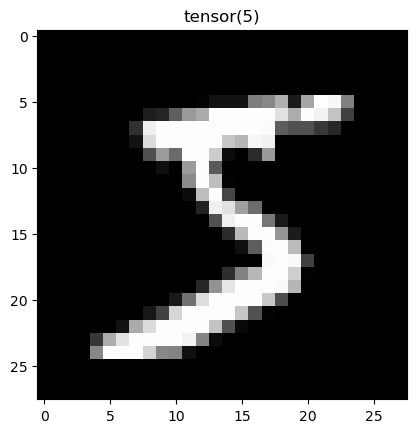

In [8]:
import matplotlib.pyplot as plt

plt.imshow(train_data.data[0],cmap='gray')
plt.title(train_data.targets[0])
plt.show()

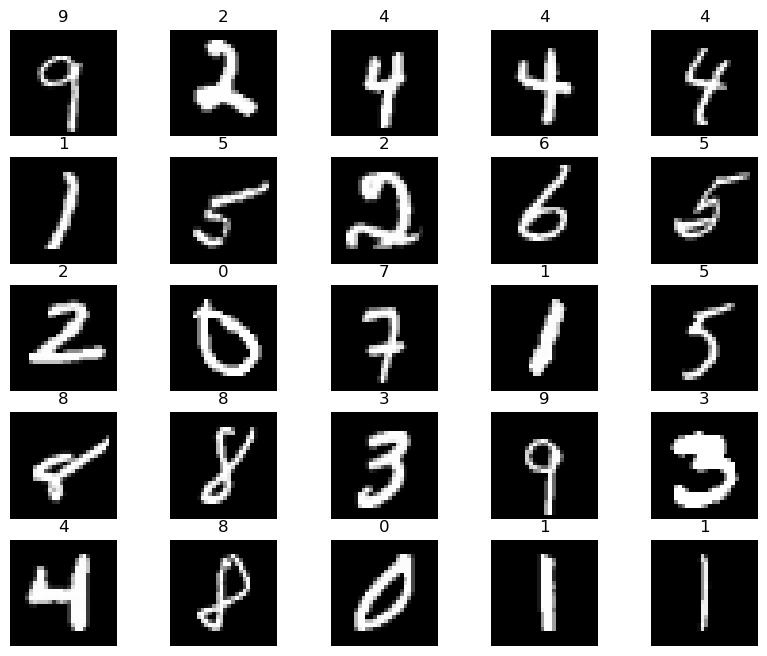

In [9]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [10]:
from sklearn.model_selection import train_test_split


train_indices, val_indices,_,_ = train_test_split(
    range(len(train_data)),
    train_data.targets,
    stratify=train_data.targets,
    test_size=0.2)

In [11]:
train_split=torch.utils.data.Subset(train_data,train_indices)
val_split=torch.utils.data.Subset(train_data,val_indices)

In [24]:
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import torch

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.batch_size = 32
        self.train_split=None
        self.val_split=None
        self.test_split=None

    def prepare_data(self):
        datasets.MNIST(root='data', train=True, transform=ToTensor(), download=True)
        datasets.MNIST(root='data', train=False, transform=ToTensor(), download=True)

    def setup(self, stage=None):
        if stage == 'fit':
            self.train_dataset = datasets.MNIST(root='data', train=True, transform=ToTensor(), download=False)
            self.test_dataset = datasets.MNIST(root='data', train=False, transform=ToTensor(), download=False)

            self.train_indices, self.val_indices, _, _ = train_test_split(
                range(len(self.train_dataset)),
                self.train_dataset.targets,
                stratify=self.train_dataset.targets,
                test_size=0.2
            )

            self.train_split = torch.utils.data.Subset(self.train_dataset, self.train_indices)
            self.val_split = torch.utils.data.Subset(self.train_dataset, self.val_indices)
            

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_split, batch_size=self.batch_size)

    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_split, batch_size=self.batch_size)

    def test_dataloader(self:p.LightningDataModule):
        self.test_indices = range(len(self.test_dataset))
        self.test_split = torch.utils.data.Subset(self.test_dataset, self.test_indices)
        return torch.utils.data.DataLoader(self.test_split, batch_size=self.batch_size)
       

In [25]:
import torch.nn as nn
import torchmetrics

class CNN(p.LightningModule):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.conv1= nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,              
                stride=1,                   
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(2))
        
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
            
        self.fc1=nn.Linear(32*7*7,10)
        
        self.train_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.valid_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.test_acc  = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        
        x = x.view(x.size(0), -1)   
        
        out=self.fc1(x)
        
        return out
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(),lr=0.001)
    
    def training_step(self, batch, batch_idx):
        x,y=batch
        y_pred=self(x)
        loss=nn.CrossEntropyLoss()(y_pred,y)
        self.train_acc(y_pred, y)
        self.log('train_acc', self.train_acc, on_step=True, on_epoch=False)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self,batch,batch_idx):
        x,y=batch
        y_pred = self(x)
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.valid_acc(y_pred, y)
        self.log('val_acc', self.valid_acc, on_step=True, on_epoch=True)
        self.log("val_loss", loss)
        
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = nn.CrossEntropyLoss()(y_pred, y)
        self.log("test_loss", loss)
        self.test_acc(y_pred, y)
        self.log('test_acc', self.test_acc)
        return loss

In [26]:
CNN()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
  (train_acc): MulticlassAccuracy()
  (valid_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
)

In [27]:
class LoggingCallback(p.Callback):
    def on_train_epoch_end(self,trainer:p.Trainer,pl_module: p.LightningModule):
        epoch = trainer.current_epoch
        logs=trainer.callback_metrics

        loss = logs.get('train_loss')
        accuracy = logs.get('train_acc')

        
        print(f"Epoch {epoch} - Training Loss: {loss} - Accuracy: {accuracy}")
    
    def on_validation_epoch_end(self, trainer: p.Trainer, pl_module: p.LightningModule) -> None:
      
        epoch = trainer.current_epoch
        logs=trainer.callback_metrics

        accuracy=logs.get('val_acc')
        loss = logs.get('val_loss')

        print(f"Epoch {epoch} - V Loss: {loss} - Accuracy: {accuracy}")
        
    

In [28]:
from pytorch_lightning.callbacks import ModelCheckpoint,EarlyStopping

checkpoint_callback = ModelCheckpoint(
        monitor='val_acc', 
        save_top_k=1, 
        mode='max',
        dirpath='saved/',
        filename='sample-mnist-{epoch:02d}-{val_loss:.2f}')
    
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)


In [29]:
datamodule = MNISTDataModule()
model = CNN()
trainer = p.Trainer(
        callbacks=[LoggingCallback(),checkpoint_callback,early_stopping_callback],
        max_epochs=2,
        
        profiler='simple'
    )
trainer.fit(model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\ASUS\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:617: UserWarning: Checkpoint directory C:\Users\ASUS\Desktop\fsdl\saved exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | conv1     | Sequential         | 416   
1 | conv2     | Sequential         | 12.8 K
2 | fc1       | Linear             | 15.7 K
3 | train_acc | MulticlassAccuracy | 0     
4 | valid_acc | MulticlassAccuracy | 0     
5 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
28.9 K    Trainable params
0         Non-trainable params
28.9 K    Total params
0.116     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0 - V Loss: 2.306661367416382 - Accuracy: 0.078125


C:\Users\ASUS\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\ASUS\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0 - V Loss: 0.06242285296320915 - Accuracy: 0.981333315372467
Epoch 0 - Training Loss: 0.1288505643606186 - Accuracy: 0.9375


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.
FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                              	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                            

Epoch 1 - V Loss: 0.05118288844823837 - Accuracy: 0.984000027179718
Epoch 1 - Training Loss: 0.0689249336719513 - Accuracy: 0.96875


In [31]:
datamodule = MNISTDataModule()
from pytorch_lightning.profiler import SimpleProfiler

profiler = SimpleProfiler()

model = CNN()
trainer = p.Trainer(
        callbacks=[LoggingCallback(),checkpoint_callback,early_stopping_callback],
        max_epochs=2,
        
        profiler=profiler
    )
trainer.fit(model, datamodule=datamodule)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_13076\3900149105.py", line 2, in <module>
    from pytorch_lightning.profiler import SimpleProfiler
ModuleNotFoundError: No module named 'pytorch_lightning.profiler'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\IPython\core\ultratb.py", line 1428, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

In [ ]:
test_dataloader= datamodule.test_dataloader()

true=[]
pred=[]

for batch in test_dataloader:
    x,y=batch
    with torch.no_grad():
        y_pred=model(x)
        
    _,predicted = torch.max(y_pred, 1)
#     print(predicted)
    
    true.extend(y.tolist())
    pred.extend(predicted.tolist())
    break

In [ ]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
#     sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img=x[i]
    figure.add_subplot(rows, cols, i)
    plt.title(pred[i])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()